# CIS-PD Test Data

In [93]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from tqdm import tqdm
import librosa
import librosa.display
from scipy.fftpack import fft 
from scipy.signal import get_window

In [94]:
# Create data directory path
datadir = 'Data/BEATPDchallenge/'

In [95]:
# load test_measurement_ids
test_measurement_ids = pd.read_csv(datadir + 'BEAT-PD_SC1_OnOff_Submission_Template.csv')

In [96]:
# view head
test_measurement_ids.head()

,measurement_id,prediction
0,0e80673b-8c90-474f-8388-00fdf25795e4,NaN
1,a7b61d40-9f26-4878-a2d7-bd766b8ae6f5,NaN
2,fc851afd-133c-4e8f-8deb-0079cc442358,NaN
3,90c2c320-1007-47b4-9f8e-cdd37067dfb2,NaN
4,379fd23b-e38f-4214-8a70-7a829004359f,NaN


In [97]:
# Create a python list of the cis-pd time series
measurements = []

for measurement in tqdm(test_measurement_ids['measurement_id']):
    try:
        measurements.append(pd.read_csv(os.path.join(datadir,'testing_data-cispd/',
                                                     measurement + '.csv')))
    # Throw out REAL data    
    except:
        test_measurement_ids = test_measurement_ids[test_measurement_ids.measurement_id != measurement]

100%|██████████| 695/695 [00:17<00:00, 39.40it/s]


In [98]:
for i, measurement in enumerate(measurements):
    measurements[i] = measurements[i].drop(columns='Timestamp')

# Preprocessing

In [99]:
# pad with 0's for measurements less than 20 minutes and trim measurements more than 20 minutes
def PrepTS(measurement):
    if measurement.index[-1] < 60000:
        pad_size = 60000 - measurement.index[-1]
        pre_pad_size = pad_size//2
        post_pad_size = pad_size//2
        pre_pad = pd.DataFrame(np.zeros((pre_pad_size, 3)),columns=['X', 'Y', 'Z'])
        post_pad = pd.DataFrame(np.zeros((post_pad_size, 3)),columns=['X', 'Y', 'Z'])
        measurement = pd.concat([measurement, post_pad]).reset_index(drop=True)
        measurement = pd.concat([pre_pad, measurement]).reset_index(drop=True)
        
    elif measurement.index[-1] > 60000:
        measurement = measurement[:60001]
        
    return measurement

In [100]:
for i, measurement in enumerate(measurements):
    measurements[i] = PrepTS(measurement)

## Center 10 Minutes

In [107]:
# function to take the center ten minutes of time series

def Center10(df):
    center = df.index[-1]//2
    return df[center-15000:center+15000] # 15000 rows => 5 minutes

In [108]:
# python list containing the center 10 minute time series
center10df = []

for df in tqdm(measurements):
    center10df.append(Center10(df))

100%|██████████| 587/587 [00:00<00:00, 10104.85it/s]


In [110]:
# Reset indexes

for i, df in enumerate(center10df):
    center10df[i] = df.reset_index(drop=True)

In [111]:
# Reset measurement_id indexes

test_measurement_ids.reset_index(drop=True, inplace=True)

In [113]:
# Number of IDs
test_measurement_ids.shape[0]

587

In [114]:
# Number of time series
len(center10df)

587

# Metadata

In [115]:
# Adding Metadata to df's

for df, id_ in zip(center10df, test_measurement_ids['measurement_id']):
                   df.measurement_id = id_

## Plot Some Samples

In [116]:
plt.style.use('ggplot')

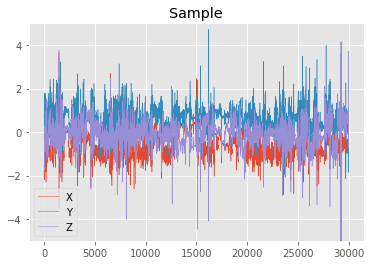

In [117]:
center10df[1].plot(ylim=(-5,5), title='Sample', linewidth=0.5)

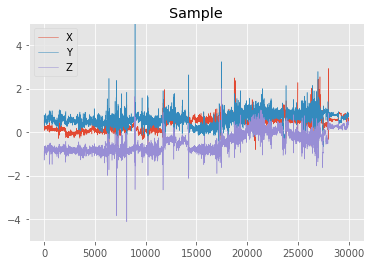

In [118]:
center10df[2].plot(ylim=(-5,5), title='Sample', linewidth=0.5)

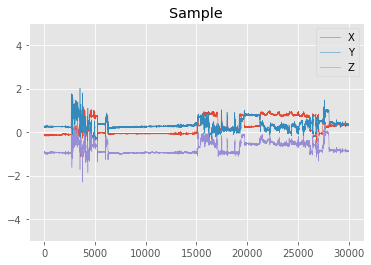

In [120]:
center10df[3].plot(ylim=(-5,5), title='Sample', linewidth=0.5)

# Magnitude

In [121]:
#Creating new column in each df containing the magnitude

for df in center10df:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

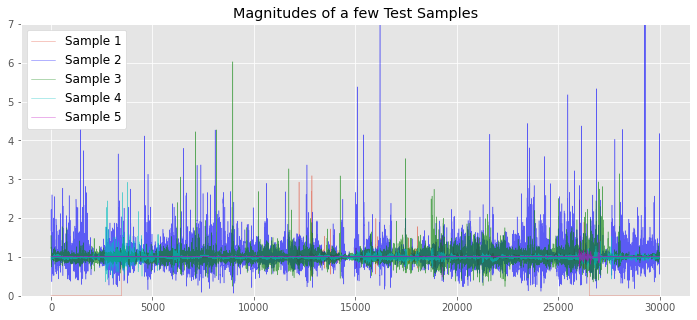

In [123]:

fig, ax = plt.subplots(figsize = (12,5), )


center10df[0].R.plot(ylim = (0,7),ax=ax, alpha = 0.6,
               title='Magnitudes of a few Test Samples', linewidth=0.5)
center10df[1].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='b',linewidth=0.5)
center10df[2].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='g',linewidth=0.5)
center10df[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='c',linewidth=0.5)
center10df[4].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='m',linewidth=0.5)
plt.legend(('Sample 1','Sample 2','Sample 3','Sample 4','Sample 5'), loc = 'upper left', fontsize='large', framealpha=1, facecolor='w' );

# Creating Spectrogram Dataset

In [134]:
# number of mel frequency bands
n_mels = 128
hop_length = 256 
sample_rate = 0.02
n_fft = 2048  # frame length

fmin = 0        
fmax = 0.01# sample_rate/2

In [135]:
# function to save spectrogram images

def SaveSpec(TS):
    
    x = TS.R.values
    
    fig, ax = plt.subplots( figsize=(12, 5))
    
    mel_spec = librosa.feature.melspectrogram(x , n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
    
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
    librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax)
    fig.patch.set_visible(False)
    ax.axis('off')
    plt.savefig(f'Data/BEATPDchallenge/CIS-PD Spectrograms/subchallenge 1 test specs/{TS.measurement_id}.png')
    plt.close()

In [137]:
######### Creating Spectrogram Datasets #########
for df in center10df:
    SaveSpec(df)